In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from dotenv import load_dotenv
import mlflow
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
#Unprocessed (unscaled data)

raw_train_df = pd.read_csv("train/splits/train_split.csv")
raw_test_df = pd.read_csv("train/splits/test_split.csv")
raw_val_df = pd.read_csv("train/splits/val_split.csv")

In [4]:
raw_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77437 entries, 0 to 77436
Data columns (total 54 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   msno                                77437 non-null  object 
 1   city                                77437 non-null  float64
 2   bd                                  77437 non-null  float64
 3   gender                              77437 non-null  object 
 4   registered_via                      77437 non-null  float64
 5   registration_init_time              77437 non-null  object 
 6   num_25_mean                         77437 non-null  float64
 7   num_50_mean                         77437 non-null  float64
 8   num_50_min                          77437 non-null  float64
 9   num_50_max                          77437 non-null  float64
 10  num_50_std                          77437 non-null  float64
 11  num_75_mean                         77437

In [3]:
raw_train_df.head()

,msno,city,bd,gender,registered_via,registration_init_time,num_25_mean,num_50_mean,num_50_min,num_50_max,...,membership_expire_day_of_week_mean,membership_expire_month_mean,membership_expire_month_count,last_transaction_date,is_churn,registration_year,registration_month,last_transaction_year,last_transaction_month,usage_period_days
0,P7W1hJVPC9+lZf5WLhskxKvQQEJJdpKkKVu4v7RA0zQ=,13.0,29.0,female,9.0,2004-03-26,2.86,0.00,0.0,0.0,...,3.0,4.0,1.0,2017-03-01,0.0,2004.0,3.0,2017.0,3.0,4723.0
1,yKDUvz1yO1xZ/fwG0bMyIa5K+w7+kIAc+qV3vZKYz9E=,22.0,36.0,female,9.0,2004-03-26,2.00,0.50,0.0,1.0,...,5.0,4.5,2.0,2017-03-31,0.0,2004.0,3.0,2017.0,3.0,4753.0
2,STy1UqGkW8U4LNr6usNMy5hpCt1fZs96eLFHmhnb0tE=,10.0,32.0,female,9.0,2004-03-26,3.00,0.50,0.0,1.0,...,6.0,4.0,1.0,2017-03-31,0.0,2004.0,3.0,2017.0,3.0,4753.0
3,35OTDI3ToY0rj1BtWTbDJ9YV8yDygsv1sNM08SQ7pQc=,22.0,33.0,female,9.0,2004-03-26,4.17,0.86,0.0,3.0,...,6.0,4.0,1.0,2017-03-31,0.0,2004.0,3.0,2017.0,3.0,4753.0
4,9CqDxOPBQwLzxCOywM3l763Yq4yFQhPhFFk79rPs5x0=,5.0,0.0,male,9.0,2004-03-26,4.11,3.83,0.0,19.0,...,0.0,4.0,1.0,2017-03-17,0.0,2004.0,3.0,2017.0,3.0,4739.0


## Preprocessing


In [11]:
TO_DROP = ["msno", "registration_init_time", "last_transaction_date"]
CATEGORICAL_FEATS = ["city", "gender", "registered_via", "registration_month", "last_transaction_month"]

def preprocess_df(df : pd.DataFrame):

    df_cp = df.copy()
    df_cp = df_cp.drop(TO_DROP, axis=1)
    ¶
    for name in CATEGORICAL_FEATS:
        df_cp[name] = df_cp[name].astype("category")


    return df_cp


In [12]:
#Apply preprocessing
train_df = preprocess_df(raw_train_df)
val_df = preprocess_df(raw_val_df)
test_df = preprocess_df(raw_test_df)

## Feature Processing

### Feature Importance Filtering
Looking at Feature Importances produced in first iteration, let's drop the most uninoformative ones.

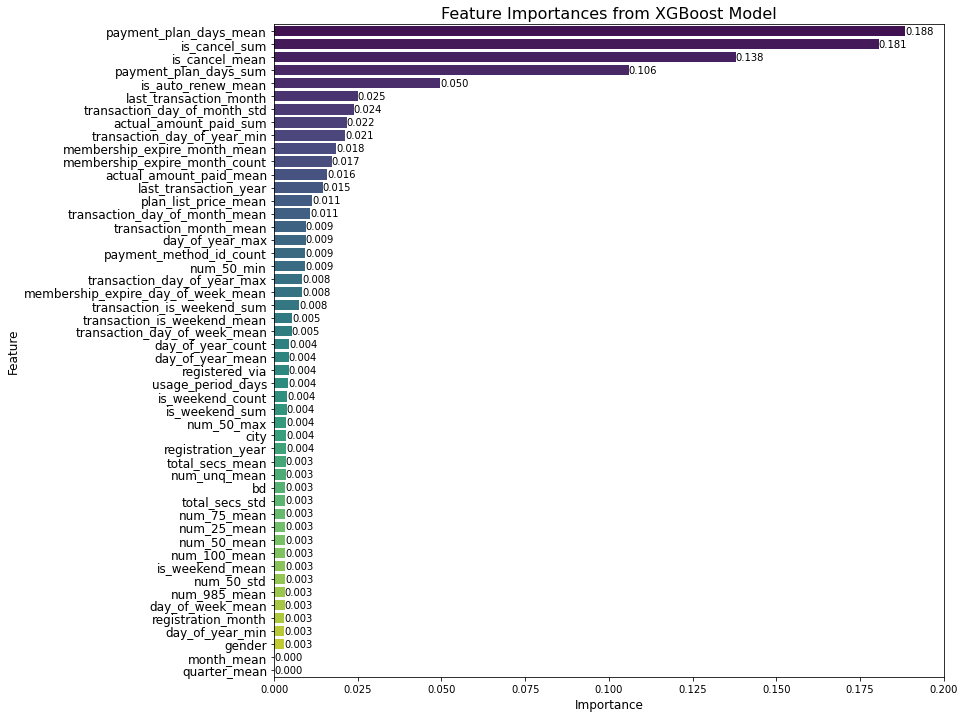

In [18]:
fi_df = pd.read_csv("artifacts/xgb_feat_importances_iter1.csv")

plt.figure(figsize=(12, 12))
sns.barplot(x="importance", y="feature", data=fi_df, palette="viridis")

for index, value in enumerate(fi_df["importance"]):
    plt.text(value, index, f'{value:.3f}', va='center')

plt.title('Feature Importances from XGBoost Model', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.xlim(0, 0.2)
plt.show()


In [40]:
fi_treshold = 0.005

IMPORTANT_FEATURES = fi_df[fi_df["importance"] >= fi_treshold]["feature"].to_list()

print("Number of Important features left:", len(IMPORTANT_FEATURES))

Number of Important features left: 24


In [44]:
train_df_filt = train_df[IMPORTANT_FEATURES + ["is_churn"]]
val_df_filt = val_df[IMPORTANT_FEATURES + ["is_churn"]]
test_df_filt = test_df[IMPORTANT_FEATURES + ["is_churn"]]

In [45]:
train_df_filt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77437 entries, 0 to 77436
Data columns (total 25 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   payment_plan_days_mean              77437 non-null  float64 
 1   is_cancel_sum                       77437 non-null  float64 
 2   is_cancel_mean                      77437 non-null  float64 
 3   payment_plan_days_sum               77437 non-null  float64 
 4   is_auto_renew_mean                  77437 non-null  float64 
 5   last_transaction_month              77437 non-null  category
 6   transaction_day_of_month_std        77437 non-null  float64 
 7   actual_amount_paid_sum              77437 non-null  float64 
 8   transaction_day_of_year_min         77437 non-null  float64 
 9   membership_expire_month_mean        77437 non-null  float64 
 10  membership_expire_month_count       77437 non-null  float64 
 11  actual_amount_paid_mean     

### Feature Correlation: Multicollinearity 

<Axes: title={'center': 'Correlation for Filtered DF'}>

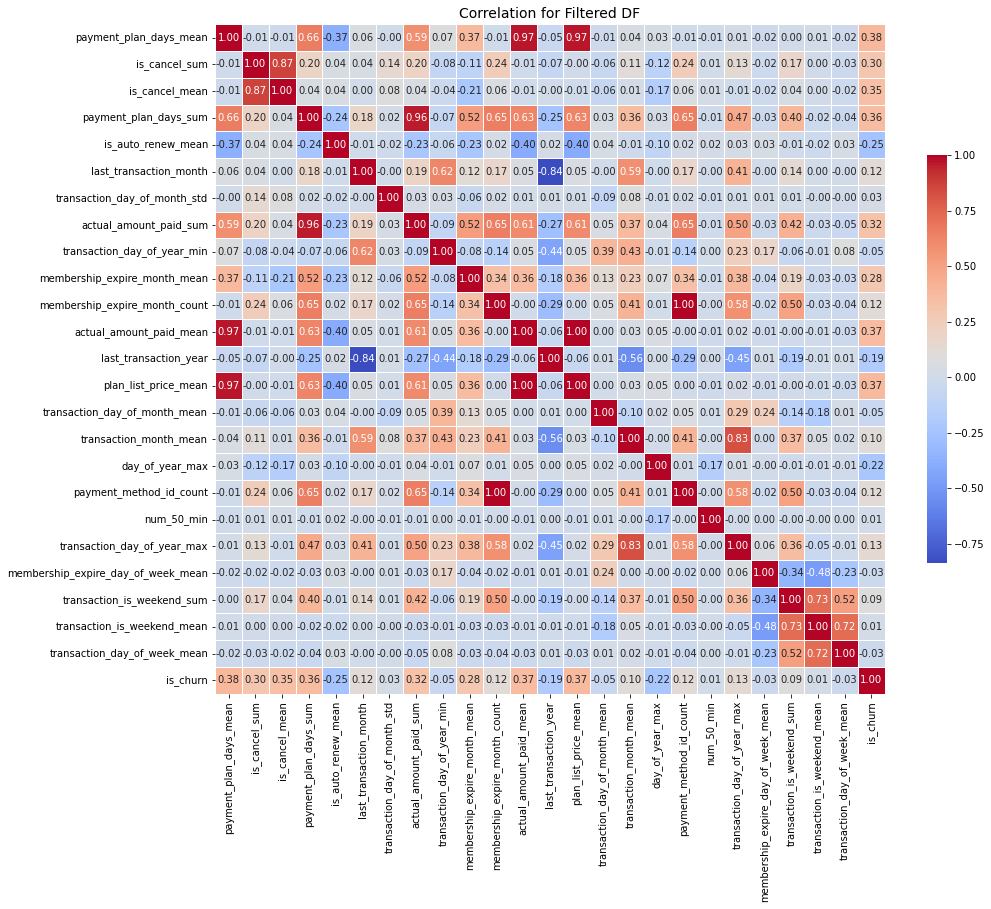

In [67]:
corr_matrix = train_df_filt.corr()
plt.figure(figsize=(15, 15))
plt.title("Correlation for Filtered DF", fontsize=14)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=1, cbar_kws={"shrink": 0.5})

**Observation:**

We clearly see that we have a **mutlicollinearity problem** because of the way we aggregated data (mean of some sample is highly correlated to sum as example). Some features are redundant because correlation is nearly 1 (e.g. payment plan days sum and actual_amount_paid_sum)

This is not a big problem in terms of performance of boosting algorithms, but it is an **issue in terms of interpretability**

In [64]:
# Create a boolean mask for the upper triangle of the correlation matrix
# Exclude the diagonal (k=1) and lower triangle, keeping only the upper triangle

high_corr_treshold = 0.7

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# Identify the features that have a high correlation (> t) with any other feature
REDUNDANT_TO_DROP = [column for column in upper.columns if any(upper[column] > high_corr_treshold)]

REDUNDANT_TO_DROP

['is_cancel_mean',
 'actual_amount_paid_sum',
 'actual_amount_paid_mean',
 'plan_list_price_mean',
 'payment_method_id_count',
 'transaction_day_of_year_max',
 'transaction_is_weekend_mean',
 'transaction_day_of_week_mean']

In [65]:
#Remove redundant features to reduce multicolinearity

train_df_reduced = train_df_filt.drop(REDUNDANT_TO_DROP, axis=1)
val_df_reduced = val_df.drop(REDUNDANT_TO_DROP, axis=1)
test_df_reduced = test_df.drop(REDUNDANT_TO_DROP, axis=1)

**Looking at correlation  matrix again**

<Axes: title={'center': 'Correlation for Filtered DF without Redundant Features'}>

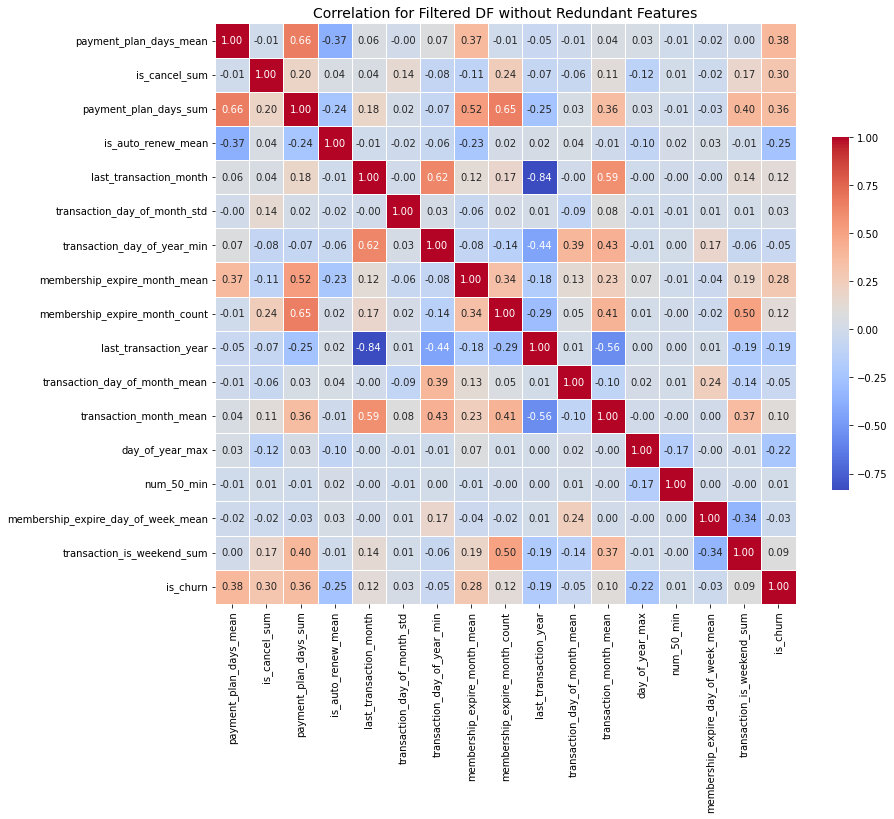

In [69]:
corr_matrix_red = train_df_reduced.corr()
plt.figure(figsize=(13, 13))
plt.title("Correlation for Filtered DF without Redundant Features", fontsize=14)
sns.heatmap(corr_matrix_red, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=1, cbar_kws={"shrink": 0.5})

Now, it looks much better because we don't have extremely correlated features. This step shouldn't hurt the performance of ml model, but it **will certainly improve or ability to interpret model's decision**